# Udacity Self-Driving Car Engineer Nanodegree

## Deep Learning
### Project: Behavioural Cloning

In this project I have built and trained deep neural network to enable a car to drive itself around the racing track in a driving simulator. The starting model is a convolutional neural network based on the [NVDIA](https://arxiv.org/pdf/1704.07911.pdf) architecture.

The project is organised by the following sections:
-  Loading Data
-  Data Preprocessing 
-  Design and Test Model Architecture
-  Model Improvement
-  Testing and Results

In [29]:
import os
import csv
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sklearn
import timeit

%matplotlib inline

from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers import Convolution2D, MaxPooling2D

import warnings
warnings.filterwarnings('ignore')

In [ ]:
cwd = os.getcwd()

### Read images log file

In [4]:
# read images log file 
lines = []

with open('data/driving_log.csv') as csvfle:
    reader = csv.reader(csvfle)
    for line in reader:
        lines.append(line)

header = lines[0]
del lines[0]

### Read images + data augmentation

In [5]:
# read images file (all 3 cameras), implement steering correction for the left and right camera
# NB: implementing steering corrections for the left and right camera allows to x3 augment the data set
images = []
measurements = []
correction = 0.25 # steering correction for the left and right camera

for line in lines:
    for i in range(3):
        source_path = line[i]
        filename = source_path.split('/')[-1]
        current_path = cwd + '/data/IMG/' + filename
        image = mpimg.imread(current_path)
        images.append(image)
    # implement steering correction for the left and right camera, save steering with corrections    
    steering_center = float(line[3])
    steering_left = steering_center + correction
    steering_right = steering_center - correction
    measurements.append(steering_center)
    measurements.append(steering_left)
    measurements.append(steering_right)

In [27]:
len(images)

10881

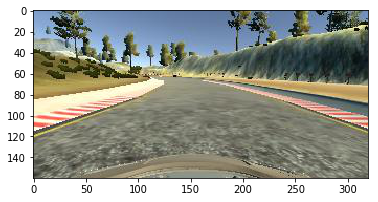

In [6]:
plt.imshow(images[0])

In [7]:
# flipping images and steering measurements (an effective technique for helping with the left turn bias)
augmented_images = []
augmetned_measurements = []
    
for image, measurement in zip(images, measurements):
    augmented_images.append(image)
    augmetned_measurements.append(measurement)
    augmented_images.append(cv2.flip(image,1))
    augmetned_measurements.append(measurement * -1)

In [8]:
X_train = np.array(augmented_images)
y_train = np.array(augmetned_measurements)

In [9]:
X_train.shape

(21762, 160, 320, 3)

### Generator

In [10]:
samples = lines
ch, row, col = 3, 80, 320  # Trimmed image format
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

In [11]:
# implement image generator - modification of baseline function from the lecture notes

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        samples = np.random.permutation(samples)
        #shuffle(samples)
        for offset in range(0, num_samples - batch_size, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                
                center_image = mpimg.imread(cwd + '/data/IMG/' +batch_sample[0].split('/')[-1])
                left_image = mpimg.imread(cwd + '/data/IMG/' +batch_sample[1].split('/')[-1])
                right_image = mpimg.imread(cwd + '/data/IMG/' +batch_sample[2].split('/')[-1])
                
                images.append(center_image)
                images.append(left_image)
                images.append(right_image)
                
                center_angle = float(batch_sample[3])
                left_angle = center_angle + correction
                right_angle = center_angle - correction
                
                angles.append(center_angle)
                angles.append(left_angle)
                angles.append(right_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

In [12]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

### Model architecture and training

In [13]:
# Baseline from the lectures - not using it due to low performance
#model= Sequential()
#model.add(Lambda(lambda x: (x/255.0) - 0.5, input_shape = (160, 320,3)))
#model.add(Flatten())
#model.add(Dense(1))

In [14]:
# LeNet architecture model
model = Sequential()
model.add(Lambda(lambda x: (x/255.0) - 0.5, input_shape = (160, 320,3)))
model.add(Cropping2D(cropping = ((70,25),(0,0))))
model.add(Convolution2D(6,5,5, activation = 'relu'))
model.add(MaxPooling2D())
model.add(Convolution2D(6,5,5, activation = 'relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(120))
model.add(Dense(84))
model.add(Dense(1))

In [18]:
# train LeNet and save LeNet model
start_time = timeit.default_timer()
model.compile(loss =  'mse', optimizer =  'adam')
history_object = model.fit(X_train, y_train, validation_split = 0.2, shuffle = True, nb_epoch = 5)
model.save('model_LeNet.h5')
elapsed = timeit.default_timer() - start_time
print('time to train LeNet model: %.2f' % (elapsed)) 

Train on 17409 samples, validate on 4353 samples
Epoch 1/5
17409/17409 [==============================] - 260s - loss: 0.0170 - val_loss: 0.0367
Epoch 2/5
17409/17409 [==============================] - 263s - loss: 0.0164 - val_loss: 0.0370
Epoch 3/5
17409/17409 [==============================] - 261s - loss: 0.0159 - val_loss: 0.0373
Epoch 4/5
17409/17409 [==============================] - 236s - loss: 0.0151 - val_loss: 0.0409
Epoch 5/5
17409/17409 [==============================] - 229s - loss: 0.0145 - val_loss: 0.0434
time to train LeNet model: 1252.29


dict_keys(['val_loss', 'loss'])


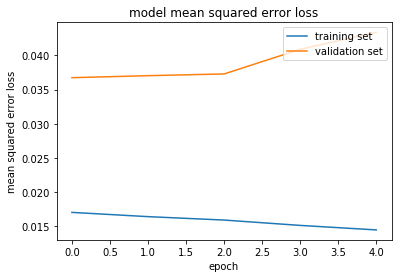

In [19]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [20]:
# train LeNet (using generator)
start_time = timeit.default_timer()
model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, samples_per_epoch= len(train_samples), validation_data=validation_generator, \
                    nb_val_samples=len(validation_samples), nb_epoch=5)
model.save('model_LeNet_generator.h5')
elapsed = timeit.default_timer() - start_time
print('time to train LeNet model using generator: %.2f' % (elapsed)) 

Epoch 1/5
2976/2901 [==============================] - 42s - loss: 0.0172 - val_loss: 0.0166
Epoch 2/5
2976/2901 [==============================] - 40s - loss: 0.0171 - val_loss: 0.0179
Epoch 3/5
2976/2901 [==============================] - 40s - loss: 0.0178 - val_loss: 0.0163
Epoch 4/5
2976/2901 [==============================] - 40s - loss: 0.0158 - val_loss: 0.0153
Epoch 5/5
2976/2901 [==============================] - 40s - loss: 0.0154 - val_loss: 0.0169
time to train LeNet model using generator: 205.79


dict_keys(['val_loss', 'loss'])


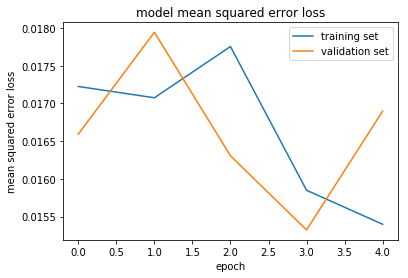

In [21]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [22]:
# modified NVDIA architecture
model = Sequential()
model.add(Lambda(lambda x: (x/255.0) - 0.5, input_shape = (160, 320,3)))
model.add(Cropping2D(cropping = ((70,25),(0,0))))
model.add(Convolution2D(24,5,5, subsample = (2,2), activation = 'relu'))
model.add(Convolution2D(36,5,5, subsample = (2,2), activation = 'relu'))
model.add(Convolution2D(48,5,5, subsample = (2,2), activation = 'relu'))
model.add(Convolution2D(64,3,3, activation = 'relu'))
model.add(Convolution2D(64,3,3, activation = 'relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(10, activation='relu'))
model.add(Dense(1)) 

In [23]:
start_time = timeit.default_timer()
model.compile(loss =  'mse', optimizer =  'adam')
mhistory_object =  model.fit(X_train, y_train, validation_split = 0.2, shuffle = True, nb_epoch = 5)
model.save('model_modified_NVDIA.h5')

elapsed = timeit.default_timer() - start_time
print('time to train modified NVDIA model: %.2f' % (elapsed)) 

Train on 17409 samples, validate on 4353 samples
Epoch 1/5
17409/17409 [==============================] - 179s - loss: 0.0338 - val_loss: 0.0371
Epoch 2/5
17409/17409 [==============================] - 177s - loss: 0.0251 - val_loss: 0.0290
Epoch 3/5
17409/17409 [==============================] - 190s - loss: 0.0221 - val_loss: 0.0295
Epoch 4/5
17409/17409 [==============================] - 206s - loss: 0.0209 - val_loss: 0.0299
Epoch 5/5
17409/17409 [==============================] - 184s - loss: 0.0198 - val_loss: 0.0320
time to train modified NVDIA model: 940.11


dict_keys(['val_loss', 'loss'])


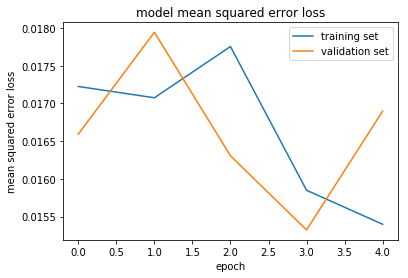

In [24]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [25]:
# train modified NVDIA model (using generator)
start_time = timeit.default_timer()
model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, samples_per_epoch= len(train_samples), validation_data=validation_generator, \
                    nb_val_samples=len(validation_samples), nb_epoch=4)
model.save('model_modified_NVDIA_generator.h5')
elapsed = timeit.default_timer() - start_time
print('time to train modified NVDIA model using generator: %.2f' % (elapsed)) 

Epoch 1/4
2976/2901 [==============================] - 36s - loss: 0.0207 - val_loss: 0.0181
Epoch 2/4
2976/2901 [==============================] - 34s - loss: 0.0191 - val_loss: 0.0152
Epoch 3/4
2976/2901 [==============================] - 32s - loss: 0.0202 - val_loss: 0.0220
Epoch 4/4
2976/2901 [==============================] - 33s - loss: 0.0197 - val_loss: 0.0167
time to train modified NVDIA model using generator: 137.35


dict_keys(['val_loss', 'loss'])


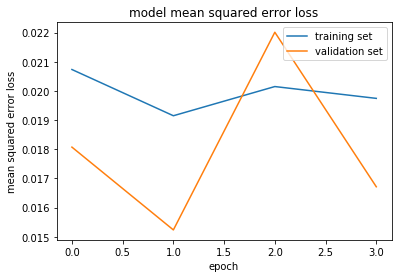

In [26]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()